Other models:  
(1) Neural Nets  

(2) Soft Voting  

(3) Stacking


# Data Preparation 

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

In [80]:
import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, \
                             GradientBoostingClassifier, \
                             ExtraTreesClassifier, \
                             VotingClassifier, \
                             AdaBoostClassifier, \
                             StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [81]:
train = pd.read_csv('/content/drive/My Drive/Competition/train.csv')
test = pd.read_csv('/content/drive/My Drive/Competition/test.csv')
sub = pd.read_csv('/content/drive/My Drive/Competition/sample_submission.csv')

# Feature Engineering

In [82]:
def month(times):
  month = []
  for each_time in times:
    time_str = str(each_time)
    each_month = time_str[4:6]
    month.append(int(each_month))
  return month

In [83]:
def add_seasons(data, train):
  new_data = data.copy()
  month_list = month(train['time'])
  new_data['winter'] = [1 if (x == 1 or x == 2 or x == 12) else 0 for x in month_list]
  new_data['summer'] = [1 if (x == 6 or x == 7 or x == 8) else 0 for x in month_list]
  new_data['automn'] = [1 if (x == 9 or x == 10 or x == 11) else 0 for x in month_list]
  new_data['spring'] = [1 if (x == 3 or x == 4 or x == 5) else 0 for x in month_list]
  return new_data

# Preprocessing

In [84]:
def preprocessing(features, removed_features):
    X = features.copy()
    X = X.drop(columns=removed_features)
   
    X_means = np.mean(X)
    X_std = np.std(X)
    X_scale = (X - X_means) / X_std
    
    return X_scale

In [85]:
def separate_train_test(train, data):
    train_data = data.iloc[0:train.shape[0], :]
    train_data_y = train.iloc[:, -1]
    test_data = data.iloc[train.shape[0]:data.shape[0], :]
    return train_data, train_data_y, test_data

In [86]:
def label_percentages(labels):
  n0 = 0
  n1 = 0
  n2 = 0
  total = labels.shape[0]
  for label in labels:
    if label == 0:
      n0 += 1
    elif label == 1:
      n1 += 1
    elif label == 2:
      n2 += 1
  
  return (n0, n1, n2), (n0/total, n1/total, n2/total), total 

In [87]:
all_features = pd.concat([train.iloc[:, :-1], test]).reset_index(drop=True)

In [88]:
X_train = train.iloc[:, 0:train.shape[1]-1]

In [89]:
y_train = train.iloc[:, -1:]

In [90]:
clean_data = preprocessing(all_features, ['S.No', 'time', 'PS', 'PRECT', 'T200'])
clean_data_fea_imp = preprocessing(all_features, ['S.No', 'time', 'PS'])

In [91]:
clean_data_add_season = add_seasons(clean_data, all_features)
data_feature_importance = add_seasons(clean_data_fea_imp, all_features)

In [92]:
fea_eng_train, train_y, fea_eng_test = separate_train_test(train, clean_data_add_season)

In [93]:
data_for_feature_importance, test1, test2 = separate_train_test(train, data_feature_importance)

In [94]:
data_for_feature_importance

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,winter,summer,automn,spring
0,-0.952799,-0.659826,-1.456660,-0.544970,1.082394,-0.689690,1.750971,-1.019028,1.385133,1.999031,-0.706613,-0.176864,-0.697123,-0.878724,1.429216,-0.428562,-0.950613,0,1,0,0
1,1.167947,0.208099,0.980482,1.330311,2.126323,1.095283,2.212530,1.028018,-1.364069,1.457275,1.322146,-0.204702,1.099047,1.426394,-1.477796,1.277024,1.390600,0,0,1,0
2,1.167947,0.185259,-1.798887,-0.270104,-1.403102,-0.220842,-1.095445,-1.715713,0.589421,-0.453372,-1.322884,-0.204702,0.408776,-0.869240,0.569875,-1.436404,-1.105605,0,0,0,1
3,0.717160,-0.393358,1.393384,0.109542,-0.322441,0.959048,-0.313340,1.097092,-1.325220,0.640182,0.839604,0.204936,0.866538,0.765701,-1.448546,0.646658,0.828448,0,0,1,0
4,-0.942553,-0.682666,-0.894244,-0.988140,-1.196643,-1.202690,-0.838749,-0.673120,1.796060,-1.153855,-0.218553,-0.177909,-0.645590,-0.435143,1.907489,-0.231807,-0.471490,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47755,-1.208927,2.050537,-1.559338,0.542162,0.960851,0.282271,0.865639,-1.501326,0.993904,-1.375851,-1.257286,-0.194378,-1.697916,-1.657530,0.967759,-1.743022,-1.610599,0,0,1,0
47756,-0.963044,-0.659826,-0.419844,1.410663,-0.103645,1.506244,-1.000442,-0.183821,0.316672,-1.348457,-0.101315,-0.193751,-0.514210,-0.159250,0.332354,-0.149713,-0.127310,0,1,0,0
47757,-1.208927,2.050537,-1.075436,1.198620,-1.466387,0.950071,-1.395281,-0.956686,0.436830,-0.253495,-0.046649,-0.186979,-1.968044,-1.510835,0.391302,-0.447305,-1.371825,0,0,1,0
47758,1.157701,0.177646,0.818513,-0.347110,0.046155,-0.779050,0.281748,1.554312,0.148711,0.020024,0.395211,0.155613,1.165682,1.152494,0.220494,0.832889,1.221467,0,1,0,0


In [95]:
fea_eng_train

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PSL,T500,TS,TREFHT,Z1000,Z200,ZBOT,winter,summer,automn,spring
0,-0.952799,-0.659826,-1.456660,-0.544970,1.082394,-0.689690,1.750971,-1.019028,1.385133,-0.706613,-0.697123,-0.878724,1.429216,-0.428562,-0.950613,0,1,0,0
1,1.167947,0.208099,0.980482,1.330311,2.126323,1.095283,2.212530,1.028018,-1.364069,1.322146,1.099047,1.426394,-1.477796,1.277024,1.390600,0,0,1,0
2,1.167947,0.185259,-1.798887,-0.270104,-1.403102,-0.220842,-1.095445,-1.715713,0.589421,-1.322884,0.408776,-0.869240,0.569875,-1.436404,-1.105605,0,0,0,1
3,0.717160,-0.393358,1.393384,0.109542,-0.322441,0.959048,-0.313340,1.097092,-1.325220,0.839604,0.866538,0.765701,-1.448546,0.646658,0.828448,0,0,1,0
4,-0.942553,-0.682666,-0.894244,-0.988140,-1.196643,-1.202690,-0.838749,-0.673120,1.796060,-0.218553,-0.645590,-0.435143,1.907489,-0.231807,-0.471490,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47755,-1.208927,2.050537,-1.559338,0.542162,0.960851,0.282271,0.865639,-1.501326,0.993904,-1.257286,-1.697916,-1.657530,0.967759,-1.743022,-1.610599,0,0,1,0
47756,-0.963044,-0.659826,-0.419844,1.410663,-0.103645,1.506244,-1.000442,-0.183821,0.316672,-0.101315,-0.514210,-0.159250,0.332354,-0.149713,-0.127310,0,1,0,0
47757,-1.208927,2.050537,-1.075436,1.198620,-1.466387,0.950071,-1.395281,-0.956686,0.436830,-0.046649,-1.968044,-1.510835,0.391302,-0.447305,-1.371825,0,0,1,0
47758,1.157701,0.177646,0.818513,-0.347110,0.046155,-0.779050,0.281748,1.554312,0.148711,0.395211,1.165682,1.152494,0.220494,0.832889,1.221467,0,1,0,0


In [96]:
train_y

0        0
1        1
2        0
3        0
4        0
        ..
47755    2
47756    2
47757    0
47758    0
47759    0
Name: LABELS, Length: 47760, dtype: int64

In [97]:
fea_eng_test

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PSL,T500,TS,TREFHT,Z1000,Z200,ZBOT,winter,summer,automn,spring
47760,-1.229417,2.042923,-0.969527,-0.199640,-0.019019,-0.908190,-0.249263,-1.533322,2.257725,-1.733819,-2.067347,-1.935251,2.280513,-1.998425,-1.874896,0,0,1,0
47761,-1.229417,2.050537,-1.033650,-0.208858,0.073115,-1.022537,-0.056414,-1.611895,2.270233,-1.714158,-2.067530,-1.970182,2.288535,-1.998483,-1.924181,0,0,1,0
47762,-1.229417,2.058150,-1.115755,-0.218882,0.146943,-1.088501,0.171496,-1.659356,2.290553,-1.704051,-2.067530,-2.027278,2.303500,-1.986739,-1.988489,0,0,1,0
47763,-1.229417,2.065764,-1.153955,-0.218557,0.240390,-1.077335,0.400787,-1.703007,2.295390,-1.678193,-2.050762,-2.081848,2.302972,-1.977785,-2.049826,0,0,1,0
47764,-1.229417,2.073377,-1.182211,-0.208022,0.401727,-1.028380,0.603821,-1.759042,2.283319,-1.628448,-2.043577,-2.088527,2.289048,-1.972756,-2.065368,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55075,1.178192,0.177646,1.257555,-0.070115,-1.906459,0.752188,-2.054562,1.622598,-1.471042,1.259184,1.119882,1.320941,-1.587032,1.305469,1.388401,0,0,1,0
55076,1.178192,0.185259,1.331331,0.049520,-2.030020,0.963159,-2.102031,1.736878,-1.543805,1.316120,1.121708,1.297473,-1.587138,1.295185,1.384040,0,0,1,0
55077,1.178192,0.192872,1.504772,0.199574,-2.240993,1.175167,-2.110102,1.825097,-1.597136,1.377637,1.138237,1.273246,-1.587472,1.303790,1.370240,0,0,1,0
55078,1.178192,0.200486,1.618416,0.349145,-2.518317,1.395306,-2.125182,1.848681,-1.645236,1.464180,1.138237,1.268741,-1.587581,1.307511,1.365763,0,0,1,0


#  Neural Nets

In [98]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [99]:
def onehot_labels(labels):
  # encode class values as integers
  encoder = LabelEncoder()
  encoder.fit(labels)
  encoded_Y = encoder.transform(labels)
  # convert integers to dummy variables (i.e. one hot encoded)
  dummy_y = np_utils.to_categorical(encoded_Y)
  return dummy_y

In [100]:
y_onehot = onehot_labels(train_y)
y_onehot.shape

(47760, 3)

In [101]:
from sklearn.model_selection import train_test_split
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(fea_eng_train, 
                                                              y_onehot, 
                                                              test_size=0.3, 
                                                              random_state=42)

X_train_nn.shape, X_val_nn.shape, y_train_nn.shape, y_val_nn.shape

((33432, 19), (14328, 19), (33432, 3), (14328, 3))

In [102]:
from tensorflow.keras import regularizers
from keras.layers import Dropout
# create model
model = Sequential()
model.add(Dense(14, input_dim=19, activation='relu'))
model.add(Dense(3, activation='softmax', kernel_regularizer='l2'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [103]:
training_result = model.fit(X_train_nn, 
                            y_train_nn, 
                            batch_size=10, 
                            epochs=50, 
                            validation_data=(X_val_nn, y_val_nn))

Epoch 1/50
3344/3344 [==============================] - 6s 2ms/step - loss: 0.5206 - accuracy: 0.7976 - val_loss: 0.4302 - val_accuracy: 0.8234
Epoch 2/50
3344/3344 [==============================] - 6s 2ms/step - loss: 0.4223 - accuracy: 0.8278 - val_loss: 0.4076 - val_accuracy: 0.8347
Epoch 3/50
3344/3344 [==============================] - 6s 2ms/step - loss: 0.4087 - accuracy: 0.8303 - val_loss: 0.4010 - val_accuracy: 0.8368
Epoch 4/50
3344/3344 [==============================] - 6s 2ms/step - loss: 0.4008 - accuracy: 0.8325 - val_loss: 0.3943 - val_accuracy: 0.8381
Epoch 5/50
3344/3344 [==============================] - 6s 2ms/step - loss: 0.3959 - accuracy: 0.8340 - val_loss: 0.3865 - val_accuracy: 0.8412
Epoch 6/50
3344/3344 [==============================] - 6s 2ms/step - loss: 0.3917 - accuracy: 0.8351 - val_loss: 0.3869 - val_accuracy: 0.8412
Epoch 7/50
3344/3344 [==============================] - 6s 2ms/step - loss: 0.3886 - accuracy: 0.8355 - val_loss: 0.3851 - val_accuracy:

In [104]:
model.evaluate(X_train_nn, y_train_nn)

1045/1045 [==============================] - 1s 1ms/step - loss: 0.3590 - accuracy: 0.8474


[0.35898593068122864, 0.8473917245864868]

In [105]:
fea_eng_test.shape

(7320, 19)

In [106]:
y_mat_prob = model.predict(fea_eng_test)

In [107]:
y_pred_nn = np.argmax(y_mat_prob, axis=1)
y_pred_nn.shape

(7320,)

In [108]:
y_pred_nn

array([0, 0, 0, ..., 1, 1, 1])

In [109]:
label_percentages(y_pred_nn)

((5547, 449, 1324),
 (0.7577868852459017, 0.06133879781420765, 0.1808743169398907),
 7320)

# Soft Voting 

In [ ]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
def accuracy_percent(model, features, label, kf):
    accuracy = cross_val_score(model, features, label, scoring='accuracy', cv=kf)
    return accuracy

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:
models = [LogisticRegression(C=0.1, solver='newton-cg'),
          SVC(C=0.1, random_state=42),
          DecisionTreeClassifier(),
          KNeighborsClassifier(n_neighbors=9),
          RandomForestClassifier(),
          GradientBoostingClassifier(), 
          ExtraTreesClassifier(),
          LGBMClassifier(),
          XGBClassifier(objective='multi:softprob', eval_metric='merror'),
         ]

In [ ]:
scores = {}

In [ ]:
names = ["Logistic Regression", 
         "SVM", 
         "Decision Tree Classifier", 
         "KNN", 
         "Random Forest Classifier", 
         "Gradient Boosting Classifier", 
         "Extra Trees Classifier", 
         "Light Gradient Boosting Machine", 
         "eXtreme Gradient Boosting"
         ]

In [ ]:
for name, model in zip(names, models):
    score = accuracy_percent(model, fea_eng_train, train_y, kfold)
    print("{}: {:.6f}, {:.4f}".format(name, score.mean(), score.std()))
    scores[name] = (score.mean(), score.std())

Logistic Regression: 0.821001, 0.0034
SVM: 0.844116, 0.0033
Decision Tree Classifier: 0.855653, 0.0025
KNN: 0.889175, 0.0027
Random Forest Classifier: 0.859883, 0.0029
Gradient Boosting Classifier: 0.863714, 0.0027
Extra Trees Classifier: 0.861642, 0.0017
Light Gradient Boosting Machine: 0.889363, 0.0031
eXtreme Gradient Boosting: 0.852931, 0.0034


In [ ]:
scores

{'DecisionTreeClassifier': (0.8562395309882748, 0.0023931711997034174),
 'ExtraTreesClassifier': (0.8617043551088777, 0.0016566198027514623),
 'GradientBoostingClassifier': (0.863714405360134, 0.0027028709485938146),
 'KNN': (0.889175041876047, 0.002669577462396826),
 'LGBM': (0.8893634840871021, 0.003108009620394584),
 'LogisticRegression': (0.821000837520938, 0.0033990609539782967),
 'RandomForestClassifier': (0.8602805695142377, 0.00253133689442334),
 'SVM': (0.8441164154103852, 0.003281329652288071),
 'XGB': (0.852931323283082, 0.003350999665414375)}

In [ ]:
final_models = [
          ('lr', LogisticRegression(solver='newton-cg')),           
          ('dt', DecisionTreeClassifier()),           
          ('rf', RandomForestClassifier()),           
          ('gb', GradientBoostingClassifier()),            
          ('etc', ExtraTreesClassifier()),           
          ('svc', SVC(probability=True)),           
          ('lgbm', LGBMClassifier()),           
          ('xgb', XGBClassifier())
          ]

In [ ]:
eclfsoft = VotingClassifier(estimators=final_models, voting='soft')
eclfsoft = eclfsoft.fit(fea_eng_train, train_y)

In [ ]:
labels_soft = eclfsoft.predict(fea_eng_test)

In [112]:
def plot_feature_importance_tree_model(X, y, model):    
    # Training the model
    model.fit(X, y)
      
    # Computing the importance of each feature
    feature_importance = model.feature_importances_
      
    # Normalizing the individual importances
    feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                            model.estimators_],
                                            axis = 0)

    plt.figure(figsize=(18,8))
    plt.bar(X.columns, feature_importance_normalized)
    plt.xlabel('Feature Labels')
    plt.ylabel('Feature Importances')
    plt.title('Comparison of different Feature Importances - Tree Model')
    plt.show()

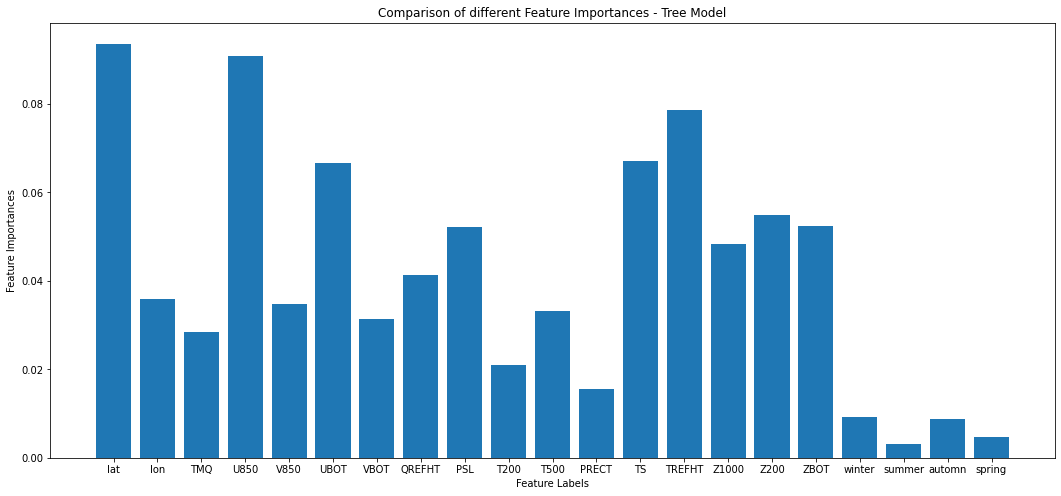

In [113]:
plot_feature_importance_tree_model(data_for_feature_importance, y_train, model=RandomForestClassifier(max_depth=7))

In [116]:
def plot_feature_importance_boost_model(X, y, model, algo_type): 
  model.fit(X, y)
  plt.figure(figsize=(18,8))
  plt.bar(X.columns, model.feature_importances_)
  plt.xlabel('Feature Labels')
  plt.ylabel('Feature Importances')
  plt.title('Comparison of different Feature Importances' + algo_type)
  plt.show()

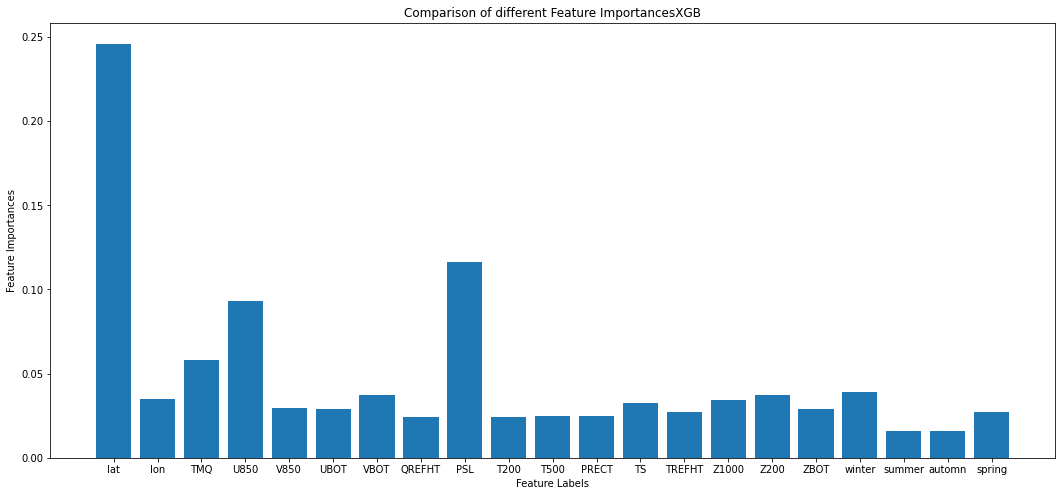

In [117]:
plot_feature_importance_boost_model(data_for_feature_importance, train_y, XGBClassifier(
    objective='multi:softmax', 
    eval_metric='merror', 
    max_depth=4), 'XGB')

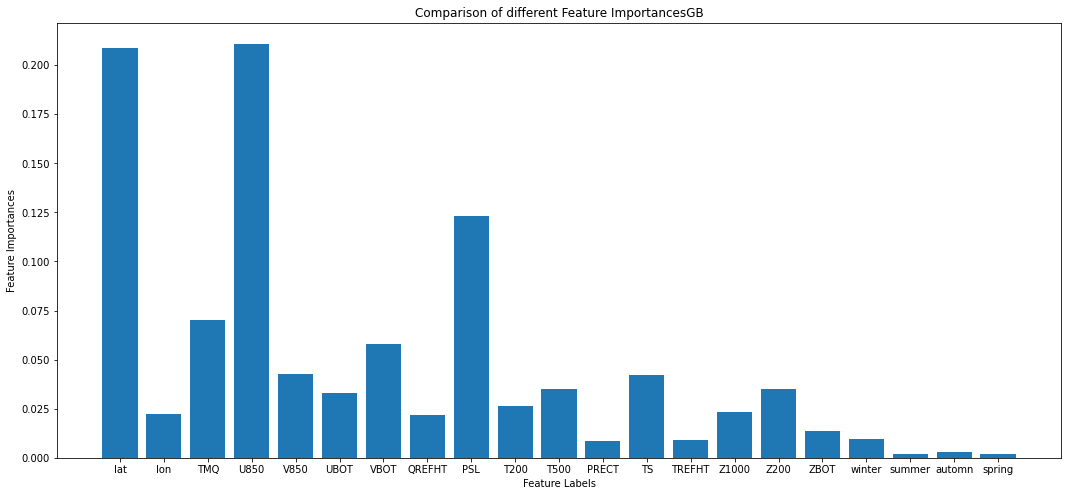

In [118]:
plot_feature_importance_boost_model(data_for_feature_importance, train_y, GradientBoostingClassifier(), 'GB')

# Stacking Classifier 

Hyperparameter tuning

In [ ]:
c_list = [0.01, 0.05, 0.1, 0.2, 0.33, 0.5, 1]
grid={"C":c_list}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg, grid, cv=10)
logreg_cv.fit(fea_eng_train,train_y)

print("tuned hyperparameters :(best parameters) ", logreg_cv.best_params_)
print("accuracy :", logreg_cv.best_score_)

tuned hyperparameters :(best parameters)  {'C': 0.1}
accuracy : 0.8217336683417085


In [ ]:
max_depth_list = [4, 5, 6, 7, 8, 9, 10]
grid={"max_depth": max_depth_list}

rf_clf = RandomForestClassifier()
rf_cv = GridSearchCV(rf_clf, grid, cv=10)
rf_cv.fit(fea_eng_train, train_y)

print("tuned hyperparameters :(best parameters) ", rf_cv.best_params_)
print("accuracy :", rf_cv.best_score_)


tuned hyperparameters :(best parameters)  {'max_depth': 10}
accuracy : 0.8793760469011724


In [ ]:
# https://xgboost.readthedocs.io/en/latest/parameter.html
params_xgb = { 
        # Increasing this value will make the model more complex and more likely to overfit        
        'max_depth': [3, 4, 5],    
        'learning_rate': [0.02, 0.05, 0.1, 0.3],
        'n_estimators' : [10, 50, 100]     
        }

xgb_clf = XGBClassifier()
xgb_cv=GridSearchCV(xgb_clf, params_xgb, cv=3)
xgb_cv.fit(fea_eng_train, train_y)
print("tuned hyperparameters :(best parameters) ", xgb_cv.best_params_)
print("accuracy :", xgb_cv.best_score_)

tuned hyperparameters :(best parameters)  {'colsample_bytree': 0.5, 'max_depth': 5, 'n_estimators': 150}
accuracy : 0.88142797319933


In [ ]:
n_neighbors = [5, 7, 9, 11, 13, 15, 17, 19, 21]
p=[1,2]
knn_params = dict(n_neighbors=n_neighbors, p=p)

knn = KNeighborsClassifier()
knn_cv=GridSearchCV(knn, knn_params, cv=3)
knn_cv.fit(fea_eng_train,train_y)

print("tuned hyperparameters :(best parameters) ", knn_cv.best_params_)
print("accuracy :", knn_cv.best_score_)

tuned hyperparameters :(best parameters)  {'n_neighbors': 19, 'p': 2}
accuracy : 0.8971105527638191


In [119]:
models = [
          ('xgb',  XGBClassifier(
                    objective='multi:softprob', 
                    eval_metric='merror', 
                    colsample_bytree=1, 
                    learning_rate=0.02, 
                    max_depth=4, 
                    n_estimators=10,
                    )
          ),
          ('gb',  GradientBoostingClassifier()),
          ('svc', SVC(C=0.1, random_state=42)),
          ('rf', RandomForestClassifier(max_depth=7))
          ]

In [120]:
clf_lr = StackingClassifier(
    estimators=models, 
    final_estimator=LogisticRegression(C=0.1, multi_class='multinomial', solver='lbfgs')
)

In [121]:
clf_lr.fit(fea_eng_train, train_y)

StackingClassifier(cv=None,
                   estimators=[('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              eval_metric='merror', gamma=0,
                                              learning_rate=0.02,
                                              max_delta_step=0, max_depth=4,
                                              min_child_weight=1, missing=None,
                                              n_estimators=10, n_jobs=1,
                                              nthread=None,
                                              objective='multi:softprob',
                                              random_state=0, reg_alpha=0...
                                                       random_state=No

In [122]:
labels_stacking_lr = clf_lr.predict(fea_eng_test)

In [123]:
label_percentages(labels_stacking_lr)

((5765, 350, 1205),
 (0.787568306010929, 0.04781420765027322, 0.1646174863387978),
 7320)

# Submission 

In [124]:
from google.colab import files
sub.iloc[:,1] = labels_stacking_lr
sub

,S.No,LABELS
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
7315,7315,0
7316,7316,1
7317,7317,1
7318,7318,1


In [125]:
sub.to_csv('submissionlabels_stacking_lr.csv', index=False)
files.download('submissionlabels_stacking_lr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>